# Perform NicheNet analysis starting from a Seurat object: step-by-step analysis 
____________________________________
Robin Browaeys 
2019-11-12 
 
<!-- github markdown built using  
rmarkdown::render("vignettes/seurat_steps.Rmd", output_format = "github_document") 
--> 
 
In this vignette, you can learn how to perform a basic NicheNet analysis 
on a Seurat v3 object. Such a NicheNet analysis can help you to generate 
hypotheses about an intercellular communication process of interest for 
which you have single-cell gene expression data as a Seurat object. 
Specifically, NicheNet can predict 1) which ligands from one or more 
cell population(s) (“sender/niche”) are most likely to affect target 
gene expression in an interacting cell population (“receiver/target”) 
and 2) which specific target genes are affected by which of these 
predicted ligands. 
 
Because NicheNet studies how ligands affect gene expression in 
putatively neighboring/interacting cells, you need to have data about 
this effect in gene expression you want to study. So, there need to be 
‘some kind of’ differential expression in a receiver cell population, 
caused by ligands from one of more interacting sender cell populations. 
 
In this vignette, we demonstrate the use of NicheNet on a Seurat Object. 
The steps of the analysis we show here are also discussed in detail in 
the main, basis, NicheNet vignette [NicheNet’s ligand activity analysis 
on a gene set of interest: predict active ligands and their target 
genes](ligand_activity_geneset.md):`vignette("ligand_activity_geneset", package="nichenetr")`. 
Make sure you understand the different steps in a NicheNet analysis that 
are described in that vignette before proceeding with this vignette and 
performing a real NicheNet analysis on your data. This vignette 
describes the different steps behind the wrapper functions that are 
shown in [Perform NicheNet analysis starting from a Seurat 
object](seurat_wrapper.md):`vignette("seurat_wrapper", package="nichenetr")`. 
Following this vignette has the advantage that it allows users to adapt 
specific steps of the pipeline to make them more appropriate for their 
data. 
 
As example expression data of interacting cells, we will use mouse 
NICHE-seq data from Medaglia et al. to explore intercellular 
communication in the T cell area in the inguinal lymph node before and 
72 hours after lymphocytic choriomeningitis virus (LCMV) infection 
(Medaglia et al. 2017). We will NicheNet to explore immune cell 
crosstalk in response to this LCMV infection. 
 
In this dataset, differential expression is observed between CD8 T cells 
in steady-state and CD8 T cells after LCMV infection. NicheNet can be 
applied to look at how several immune cell populations in the lymph node 
(i.e., monocytes, dendritic cells, NK cells, B cells, CD4 T cells) can 
regulate and induce these observed gene expression changes. NicheNet 
will specifically prioritize ligands from these immune cells and their 
target genes that change in expression upon LCMV infection. 
 
The used NicheNet networks, ligand-target matrix and example expression 
data of interacting cells can be downloaded from Zenodo. The NicheNet 
networks and ligand-target matrix at 
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3260758.svg)](https://doi.org/10.5281/zenodo.3260758) 
and the Seurat object of the processed NICHE-seq single-cell data at 
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3531889.svg)](https://doi.org/10.5281/zenodo.3531889). 
 

# Prepare NicheNet analysis 
 
## Load required packages, read in the Seurat object with processed expression data of interacting cells and NicheNet’s ligand-target prior model, ligand-receptor network and weighted integrated networks. 
 
The NicheNet ligand-receptor network and weighted networks are necessary 
to define and show possible ligand-receptor interactions between two 
cell populations. The ligand-target matrix denotes the prior potential 
that particular ligands might regulate the expression of particular 
target genes. This matrix is necessary to prioritize possible 
ligand-receptor interactions based on observed gene expression effects 
(i.e. NicheNet’s ligand activity analysis) and infer affected target 
genes of these prioritized ligands. 
 
### Load Packages and set data paths: 
 

In [1]:
library(SeuratDisk)
library(nichenetr)
library(Seurat) # please update to Seurat V4 
library(tidyverse) 

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Attaching SeuratObject

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [21]:
test_obj = readRDS(file.path(proj_root, "data", "seuratObj.rds"))
test_obj@meta.data %>% head()

,nGene,nUMI,orig.ident,aggregate,res.0.6,celltype,nCount_RNA,nFeature_RNA
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
W380370,880,1611,LN_SS,SS,1,CD8 T,1607,876
W380372,541,891,LN_SS,SS,0,CD4 T,885,536
W380374,742,1229,LN_SS,SS,0,CD4 T,1223,737
W380378,847,1546,LN_SS,SS,1,CD8 T,1537,838
W380379,839,1606,LN_SS,SS,0,CD4 T,1603,836
W380381,517,844,LN_SS,SS,0,CD4 T,840,513


In [121]:
unique(test_obj@meta.data$celltype)

[1] "CD8 T" "CD4 T" "Treg"  "B"     "NK"    "Mono"  "DC"

In [2]:
data_root <- '/lustre/scratch126/cellgen/team205/nh3/skin'
proj_root <- '~/FCA_Fetal_Skin_priv'

 
If you would use and load other packages, we recommend to load these 3 
packages after the others. 
 
### Read in the expression data of interacting cells: 
 
The dataset used here is publicly available single-cell data from immune 
cells in the T cell area of the inguinal lymph node. The data was 
processed and aggregated by applying the Seurat alignment pipeline. The 
Seurat object contains this aggregated data. Note that this should be a 
Seurat v3 object and that gene should be named by their official 
mouse/human gene symbol. 
 


In [3]:
seuratObj = LoadH5Seurat(file.path(proj_root, "data", "pooled_fetal_organoid.count_with_annot.h5seurat"))
seuratObj@meta.data %>% head() 
##         nGene nUMI orig.ident aggregate res.0.6 celltype nCount_RNA nFeature_RNA 
## W380370   880 1611      LN_SS        SS       1    CD8 T       1607          876 
## W380372   541  891      LN_SS        SS       0    CD4 T        885          536 
## W380374   742 1229      LN_SS        SS       0    CD4 T       1223          737 
## W380378   847 1546      LN_SS        SS       1    CD8 T       1537          838 
## W380379   839 1606      LN_SS        SS       0    CD4 T       1603          836 
## W380381   517  844      LN_SS        SS       0    CD4 T        840          513 


Validating h5Seurat file

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Initializing RNA with data

Adding counts for RNA

Adding feature-level metadata for RNA

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



,dataset,donor,pcw,day,sample_id,fetal_annot,organoid_annot,pooled_annot,chemistry,gender,sorting
,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AAACCTGGTCAGTGGA-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,LYVE1++ macrophage,nan,fetal_LYVE1++ macrophage,SC3Pv2,male,CD45P
AAAGATGGTCGATTGT-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,Monocyte (activated/differentiating),nan,fetal_Monocyte (activated/differentiating),SC3Pv2,male,CD45P
AAAGCAAAGATGTGGC-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,LYVE1++ macrophage,nan,fetal_LYVE1++ macrophage,SC3Pv2,male,CD45P
AAAGTAGCAGATCGGA-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,Eo/baso/mast cell progenitor,nan,fetal_Eo/baso/mast cell progenitor,SC3Pv2,male,CD45P
AAAGTAGTCCGCATCT-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,LYVE1++ macrophage,nan,fetal_LYVE1++ macrophage,SC3Pv2,male,CD45P
AAATGCCAGCTGCCCA-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,LYVE1++ macrophage,nan,fetal_LYVE1++ macrophage,SC3Pv2,male,CD45P


### Setting the Seurat Idents for the object from barcodes to cell types (i.e. pooled_annot column)

This is required because `get_expressed_genes` function uses Idents when passing sender/receiver cell types list to it.

In [4]:
seuratObj[["barcode"]] <- colnames(seuratObj)

In [5]:
seuratObj@meta.data %>% head() 


,dataset,donor,pcw,day,sample_id,fetal_annot,organoid_annot,pooled_annot,chemistry,gender,sorting,barcode
,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
AAACCTGGTCAGTGGA-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,LYVE1++ macrophage,nan,fetal_LYVE1++ macrophage,SC3Pv2,male,CD45P,AAACCTGGTCAGTGGA-1-4834STDY7002879-fetal
AAAGATGGTCGATTGT-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,Monocyte (activated/differentiating),nan,fetal_Monocyte (activated/differentiating),SC3Pv2,male,CD45P,AAAGATGGTCGATTGT-1-4834STDY7002879-fetal
AAAGCAAAGATGTGGC-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,LYVE1++ macrophage,nan,fetal_LYVE1++ macrophage,SC3Pv2,male,CD45P,AAAGCAAAGATGTGGC-1-4834STDY7002879-fetal
AAAGTAGCAGATCGGA-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,Eo/baso/mast cell progenitor,nan,fetal_Eo/baso/mast cell progenitor,SC3Pv2,male,CD45P,AAAGTAGCAGATCGGA-1-4834STDY7002879-fetal
AAAGTAGTCCGCATCT-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,LYVE1++ macrophage,nan,fetal_LYVE1++ macrophage,SC3Pv2,male,CD45P,AAAGTAGTCCGCATCT-1-4834STDY7002879-fetal
AAATGCCAGCTGCCCA-1-4834STDY7002879-fetal,fetal,F16,8,NaN,4834STDY7002879,LYVE1++ macrophage,nan,fetal_LYVE1++ macrophage,SC3Pv2,male,CD45P,AAATGCCAGCTGCCCA-1-4834STDY7002879-fetal


In [23]:
seuratObj[["trimester"]] <- ifelse(seuratObj@meta.data$pcw < 12, "1st_trimester", "2nd_trimester")
seuratObj

An object of class Seurat 
46794 features across 186533 samples within 1 assay 
Active assay: RNA (46794 features, 0 variable features)

In [26]:
seuratObj@meta.data$trimester %>% table()

.
1st_trimester 2nd_trimester 
        87212         99321 

In [6]:
seuratObj@meta.data$pooled_annot %>% head()

[1] fetal_LYVE1++ macrophage                  
[2] fetal_Monocyte (activated/differentiating)
[3] fetal_LYVE1++ macrophage                  
[4] fetal_Eo/baso/mast cell progenitor        
[5] fetal_LYVE1++ macrophage                  
[6] fetal_LYVE1++ macrophage                  
117 Levels: fetal_ASDC fetal_Adipocytes fetal_Arterial ... organoid_Uncertain

In [7]:
Idents(seuratObj) <- seuratObj@meta.data$pooled_annot

In [12]:
Idents(seuratObj) %>% head()

AAACCTGGTCAGTGGA-1-4834STDY7002879-fetal 
                  fetal_LYVE1++ macrophage 
  AAAGATGGTCGATTGT-1-4834STDY7002879-fetal 
fetal_Monocyte (activated/differentiating) 
  AAAGCAAAGATGTGGC-1-4834STDY7002879-fetal 
                  fetal_LYVE1++ macrophage 
  AAAGTAGCAGATCGGA-1-4834STDY7002879-fetal 
        fetal_Eo/baso/mast cell progenitor 
  AAAGTAGTCCGCATCT-1-4834STDY7002879-fetal 
                  fetal_LYVE1++ macrophage 
  AAATGCCAGCTGCCCA-1-4834STDY7002879-fetal 
                  fetal_LYVE1++ macrophage 
83 Levels: fetal_ASDC fetal_Adipocytes fetal_Arterial ... fetal_pDC

### subsetting data fetal data only

In [ ]:
c("fetal_Dermal papillia")

In [ ]:
c("fetal_Arterial", "fetal_Capillary (venular tip)", "fetal_Capillary/postcapillary venule", 
  "fetal_Early endothelial cell", "fetal_Tip cell (arterial)")

In [9]:
sub_list = as.vector(unique(Idents(seuratObj)[grepl("fetal", Idents(seuratObj))]))

In [10]:
seuratObj = subset(seuratObj, idents = sub_list)

In [32]:
table(Idents(seuratObj))


                                 fetal_ASDC 
                                         90 
                           fetal_Adipocytes 
                                       3203 
                             fetal_Arterial 
                                        172 
                               fetal_B cell 
                                       1982 
                                fetal_Basal 
                                        815 
                           fetal_CD4 T cell 
                                       4675 
                           fetal_CD8 T cell 
                                       1519 
              fetal_Capillary (venular tip) 
                                        487 
       fetal_Capillary/postcapillary venule 
                                        609 
                      fetal_Companion layer 
                                         27 
                       fetal_Cuticle/cortex 
                                         21 
         

In [13]:
seuratObj

An object of class Seurat 
46794 features across 186533 samples within 1 assay 
Active assay: RNA (46794 features, 0 variable features)

 
Visualize which cell populations are present: CD4 T cells (including 
regulatory T cells), CD8 T cells, B cells, NK cells, dendritic cells 
(DCs) and inflammatory monocytes 
 


In [34]:
seuratObj@meta.data$pooled_annot %>% table() # note that the number of cells of some cell types is very low and should preferably be higher for a real application 
## . 
##     B CD4 T CD8 T    DC  Mono    NK  Treg  
##   382  2562  1645    18    90   131   199 
# DimPlot(seuratObj, reduction = "tsne")


.
                                    fetal_ASDC 
                                            90 
                              fetal_Adipocytes 
                                          3203 
                                fetal_Arterial 
                                           172 
                                  fetal_B cell 
                                          1982 
                                   fetal_Basal 
                                           815 
                              fetal_CD4 T cell 
                                          4675 
                              fetal_CD8 T cell 
                                          1519 
                 fetal_Capillary (venular tip) 
                                           487 
          fetal_Capillary/postcapillary venule 
                                           609 
                         fetal_Companion layer 
                                            27 
                          fetal_Cuticl

 
![](seurat_steps_files/figure-gfm/unnamed-chunk-23-1.png)<!-- --> 
 
Visualize the data to see to which condition cells belong. The metadata 
dataframe column that denotes the condition (steady-state or after LCMV 
infection) is here called ‘aggregate.’ 
 


In [ ]:
seuratObj@meta.data$aggregate %>% table() 
## . 
## LCMV   SS  
## 3886 1141 
DimPlot(seuratObj, reduction = "tsne", group.by = "aggregate")


 
![](seurat_steps_files/figure-gfm/unnamed-chunk-24-1.png)<!-- --> 
 
### Read in NicheNet’s ligand-target prior model, ligand-receptor network and weighted integrated networks: 
 


In [14]:
ligand_target_matrix = readRDS(file.path(proj_root, "data", "ligand_target_matrix.rds")) 
ligand_target_matrix[1:5,1:5] # target genes in rows, ligands in columns 
##                 CXCL1        CXCL2        CXCL3        CXCL5         PPBP 
## A1BG     3.534343e-04 4.041324e-04 3.729920e-04 3.080640e-04 2.628388e-04 
## A1BG-AS1 1.650894e-04 1.509213e-04 1.583594e-04 1.317253e-04 1.231819e-04 
## A1CF     5.787175e-04 4.596295e-04 3.895907e-04 3.293275e-04 3.211944e-04 
## A2M      6.027058e-04 5.996617e-04 5.164365e-04 4.517236e-04 4.590521e-04 
## A2M-AS1  8.898724e-05 8.243341e-05 7.484018e-05 4.912514e-05 5.120439e-05 

,CXCL1,CXCL2,CXCL3,CXCL5,PPBP
A1BG,3.534343e-04,4.041324e-04,3.729920e-04,3.080640e-04,2.628388e-04
A1BG-AS1,1.650894e-04,1.509213e-04,1.583594e-04,1.317253e-04,1.231819e-04
A1CF,5.787175e-04,4.596295e-04,3.895907e-04,3.293275e-04,3.211944e-04
A2M,6.027058e-04,5.996617e-04,5.164365e-04,4.517236e-04,4.590521e-04
A2M-AS1,8.898724e-05,8.243341e-05,7.484018e-05,4.912514e-05,5.120439e-05


In [15]:
lr_network = readRDS(file.path(proj_root, "data", "lr_network.rds"))
head(lr_network) 
## # A tibble: 6 x 4 
##   from  to    source         database 
##   <chr> <chr> <chr>          <chr>    
## 1 CXCL1 CXCR2 kegg_cytokines kegg     
## 2 CXCL2 CXCR2 kegg_cytokines kegg     
## 3 CXCL3 CXCR2 kegg_cytokines kegg     
## 4 CXCL5 CXCR2 kegg_cytokines kegg     
## 5 PPBP  CXCR2 kegg_cytokines kegg     
## 6 CXCL6 CXCR2 kegg_cytokines kegg 

from,to,source,database
<chr>,<chr>,<chr>,<chr>
CXCL1,CXCR2,kegg_cytokines,kegg
CXCL2,CXCR2,kegg_cytokines,kegg
CXCL3,CXCR2,kegg_cytokines,kegg
CXCL5,CXCR2,kegg_cytokines,kegg
PPBP,CXCR2,kegg_cytokines,kegg
CXCL6,CXCR2,kegg_cytokines,kegg


In [16]:
 
weighted_networks = readRDS(file.path(proj_root, "data", "weighted_networks.rds")) 
weighted_networks_lr = weighted_networks$lr_sig %>% inner_join(lr_network %>% distinct(from,to), by = c("from","to")) 
 
head(weighted_networks$lr_sig) # interactions and their weights in the ligand-receptor + signaling network 
## # A tibble: 6 x 3 
##   from  to     weight 
##   <chr> <chr>   <dbl> 
## 1 A1BG  ABCC6  0.422  
## 2 A1BG  ACE2   0.101  
## 3 A1BG  ADAM10 0.0970 
## 4 A1BG  AGO1   0.0525 
## 5 A1BG  AKT1   0.0855 
## 6 A1BG  ANXA7  0.457 

from,to,weight
<chr>,<chr>,<dbl>
A1BG,ABCC6,0.42164389
A1BG,ACE2,0.10074109
A1BG,ADAM10,0.09698978
A1BG,AGO1,0.05245879
A1BG,AKT1,0.08553468
A1BG,ANXA7,0.45659947


In [17]:
head(weighted_networks$gr) # interactions and their weights in the gene regulatory network 
## # A tibble: 6 x 3 
##   from  to     weight 
##   <chr> <chr>   <dbl> 
## 1 A1BG  A2M    0.0294 
## 2 AAAS  GFAP   0.0290 
## 3 AADAC CYP3A4 0.0422 
## 4 AADAC IRF8   0.0275 
## 5 AATF  ATM    0.0330 
## 6 AATF  ATR    0.0355 

from,to,weight
<chr>,<chr>,<dbl>
A1BG,A2M,0.02944793
AAAS,GFAP,0.02904173
AADAC,CYP3A4,0.04215706
AADAC,IRF8,0.02745930
AATF,ATM,0.03299318
AATF,ATR,0.03545127


 
Because the expression data is of mouse origin, we will convert the 
NicheNet network gene symbols from human to mouse based on one-to-one 
orthology: 
 


<font color="red">Since the data is human we must skip this step</font>

In [ ]:
# lr_network = lr_network %>% mutate(from = convert_human_to_mouse_symbols(from), to = convert_human_to_mouse_symbols(to)) %>% drop_na() 
# colnames(ligand_target_matrix) = ligand_target_matrix %>% colnames() %>% convert_human_to_mouse_symbols() 
# rownames(ligand_target_matrix) = ligand_target_matrix %>% rownames() %>% convert_human_to_mouse_symbols() 
 
# ligand_target_matrix = ligand_target_matrix %>% .[!is.na(rownames(ligand_target_matrix)), !is.na(colnames(ligand_target_matrix))] 
 
# weighted_networks_lr = weighted_networks_lr %>% mutate(from = convert_human_to_mouse_symbols(from), to = convert_human_to_mouse_symbols(to)) %>% drop_na() 


 
# Perform the NicheNet analysis 
 
In this case study, we want to apply NicheNet to predict which ligands 
expressed by all immune cells in the T cell area of the lymph node are 
most likely to have induced the differential expression in CD8 T cells 
after LCMV infection. 
 
As described in the main vignette, the pipeline of a basic NicheNet 
analysis consist of the following steps: 
 
## 1. Define a “sender/niche” cell population and a “receiver/target” cell population present in your expression data and determine which genes are expressed in both populations 
 
In this case study, the receiver cell population is the ‘CD8 T’ cell 
population, whereas the sender cell populations are ‘CD4 T,’ ‘Treg,’ 
‘Mono,’ ‘NK,’ ‘B’ and ‘DC.’ We will consider a gene to be expressed when 
it is expressed in at least 10% of cells in one cluster. 
 


In [19]:
## receiver 
receiver = c("fetal_Arterial", "fetal_Capillary (venular tip)", "fetal_Capillary/postcapillary venule", 
             "fetal_Early endothelial cell", "fetal_Tip cell (arterial)")
expressed_genes_receiver = get_expressed_genes(receiver, seuratObj, pct = 0.10) 
 
background_expressed_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)] 


In [25]:
endo_cells_patts = c("Postcapillary venule", "Capillary", "Tip cell", "Arterial")
endo_cells_patts = paste(endo_cells_patts, collapse="|")

In [47]:
unique(seuratObj$pooled_annot[grepl("macrophage", seuratObj$pooled_annot) & 
                              grepl("fetal", seuratObj$pooled_annot)])

[1] fetal_LYVE1++ macrophage        fetal_TREM2+ macrophage        
[3] fetal_Iron-recycling macrophage fetal_MHCII+ macrophage        
117 Levels: fetal_ASDC fetal_Adipocytes fetal_Arterial ... organoid_Uncertain

In [20]:
## sender
# sender_celltypes = unique(seuratObj$pooled_annot[grepl("macrophage", seuratObj$pooled_annot) & 
#                                                  grepl("fetal", seuratObj$pooled_annot)])
sender_celltypes = c("fetal_LYVE1++ macrophage", "fetal_TREM2+ macrophage", 
                     "fetal_Iron-recycling macrophage", "fetal_MHCII+ macrophage")
 
list_expressed_genes_sender = sender_celltypes %>% unique() %>% lapply(get_expressed_genes, seuratObj, 0.10) # lapply to get the expressed genes of every sender cell type separately here 
expressed_genes_sender = list_expressed_genes_sender %>% unlist() %>% unique() 


 
## 2. Define a gene set of interest: these are the genes in the “receiver/target” cell population that are potentially affected by ligands expressed by interacting cells (e.g. genes differentially expressed upon cell-cell interaction) 
 
Here, the gene set of interest are the genes differentially expressed in 
CD8 T cells after LCMV infection. The condition of interest is thus 
‘LCMV,’ whereas the reference/steady-state condition is ‘SS.’ The notion 
of conditions can be extracted from the metadata column ‘aggregate.’ The 
method to calculate the differential expression is here the standard 
Seurat Wilcoxon test, but this can be changed if necessary. 
 


In [28]:
seurat_obj_receiver= subset(seuratObj, idents = receiver) 
seurat_obj_receiver = SetIdent(seurat_obj_receiver, value = seurat_obj_receiver[["trimester"]]) 

condition_oi = "2nd_trimester" 
condition_reference = "1st_trimester"  
   
DE_table_receiver = FindMarkers(object = seurat_obj_receiver, ident.1 = condition_oi, ident.2 = condition_reference, min.pct = 0.10) %>% rownames_to_column("gene") 
 
geneset_oi = DE_table_receiver %>% filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25) %>% pull(gene) 
geneset_oi = geneset_oi %>% .[. %in% rownames(ligand_target_matrix)] 


 
## 3. Define a set of potential ligands: these are ligands that are expressed by the “sender/niche” cell population and bind a (putative) receptor expressed by the “receiver/target” population 
 
Because we combined the expressed genes of each sender cell type, in 
this example, we will perform one NicheNet analysis by pooling all 
ligands from all cell types together. Later on during the interpretation 
of the output, we will check which sender cell type expresses which 
ligand. 
 


In [29]:
ligands = lr_network %>% pull(from) %>% unique() 
receptors = lr_network %>% pull(to) %>% unique() 
 
expressed_ligands = intersect(ligands,expressed_genes_sender) 
expressed_receptors = intersect(receptors,expressed_genes_receiver) 
 
potential_ligands = lr_network %>% filter(from %in% expressed_ligands & to %in% expressed_receptors) %>% pull(from) %>% unique() 


 
## 4) Perform NicheNet ligand activity analysis: rank the potential ligands based on the presence of their target genes in the gene set of interest (compared to the background set of genes) 
 


In [30]:
ligand_activities = predict_ligand_activities(geneset = geneset_oi, background_expressed_genes = background_expressed_genes, ligand_target_matrix = ligand_target_matrix, potential_ligands = potential_ligands) 
 
ligand_activities = ligand_activities %>% arrange(-pearson) %>% mutate(rank = rank(desc(pearson))) 
ligand_activities 
## # A tibble: 44 x 5 
##    test_ligand auroc  aupr pearson  rank 
##    <chr>       <dbl> <dbl>   <dbl> <dbl> 
##  1 Ebi3        0.638 0.234  0.197      1 
##  2 Il15        0.582 0.163  0.0961     2 
##  3 Crlf2       0.549 0.163  0.0758     3 
##  4 App         0.499 0.141  0.0655     4 
##  5 Tgfb1       0.494 0.140  0.0558     5 
##  6 Ptprc       0.536 0.149  0.0554     6 
##  7 H2-M3       0.525 0.157  0.0528     7 
##  8 Icam1       0.543 0.142  0.0486     8 
##  9 Cxcl10      0.531 0.141  0.0408     9 
## 10 Adam17      0.517 0.137  0.0359    10 
## # ... with 34 more rows 


test_ligand,auroc,aupr,aupr_corrected,pearson,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HMGB2,0.5873329,0.2313718,0.07667036,0.14947153,1
ITGA4,0.5902294,0.2124707,0.05776930,0.11583374,2
YARS,0.5931422,0.2096774,0.05497594,0.11583143,3
VCAM1,0.5907285,0.2109802,0.05627876,0.11385275,4
DSC2,0.5845116,0.2090477,0.05434623,0.10965064,5
PLXNB2,0.5827007,0.2084627,0.05376126,0.10912473,6
CD99,0.5821402,0.2081283,0.05342690,0.10742852,7
COPA,0.5845246,0.2075883,0.05288683,0.10696126,8
TGFB1,0.5711061,0.2086266,0.05392515,0.10603848,9


 
The different ligand activity measures (auroc, aupr, pearson correlation 
coefficient) are a measure for how well a ligand can predict the 
observed differentially expressed genes compared to the background of 
expressed genes. In our validation study, we showed that the pearson 
correlation coefficient between a ligand’s target predictions and the 
observed transcriptional response was the most informative measure to 
define ligand activity. Therefore, NicheNet ranks the ligands based on 
their pearson correlation coefficient. This allows us to prioritize 
ligands inducing the antiviral response in CD8 T cells. 
 
The number of top-ranked ligands that are further used to predict active 
target genes and construct an active ligand-receptor network is here 20. 
 


In [31]:
best_upstream_ligands = ligand_activities %>% top_n(20, pearson) %>% arrange(-pearson) %>% pull(test_ligand) %>% unique() 



 
These ligands are expressed by one or more of the input sender cells. To 
see which cell population expresses which of these top-ranked ligands, 
you can run the following: 
 


In [59]:
goi_set = c("BMP4", "CXCL8", "EGFL7", "TNF", "ADM", "BMPR2", "LRP6", "ACKR1", "TNFRSF1A", "TNFRSF1B", 
            "RAMP2", "WNT5A", "RSPO3", "BMPR2", "LRP6", "FZD8", "LRP6", "FZD8", "MECOM", "GATA2", "SOX17", 
            "TAL1", "SOX7", "APLNR", "KDR", "FLT1", "CXCR4", "VWF", "CAV1", "AQP1")

In [60]:
goi_set = paste0('^',goi_set,'$')
goi_set

[1] "^BMP4$"     "^CXCL8$"    "^EGFL7$"    "^TNF$"      "^ADM$"     
 [6] "^BMPR2$"    "^LRP6$"     "^ACKR1$"    "^TNFRSF1A$" "^TNFRSF1B$"
[11] "^RAMP2$"    "^WNT5A$"    "^RSPO3$"    "^BMPR2$"    "^LRP6$"    
[16] "^FZD8$"     "^LRP6$"     "^FZD8$"     "^MECOM$"    "^GATA2$"   
[21] "^SOX17$"    "^TAL1$"     "^SOX7$"     "^APLNR$"    "^KDR$"     
[26] "^FLT1$"     "^CXCR4$"    "^VWF$"      "^CAV1$"     "^AQP1$"

In [61]:
goi_obj_sub = seuratObj[grepl(paste(goi_set, collapse="|"), rownames(seuratObj)), ]

In [79]:
best_goi_list = c(best_upstream_ligands, rownames(goi_obj_sub))

In [112]:
seuratObj[['groups']] <- sample(x = c('g1', 'g2'), size = ncol(x = seuratObj), replace = TRUE)

[1] "HMGB2"    "ITGA4"    "YARS"     "VCAM1"    "DSC2"     "PLXNB2"  
 [7] "CD99"     "COPA"     "TGFB1"    "SEMA4D"   "EFNB1"    "GSTP1"   
[13] "ITGB1"    "RPS19"    "BMP2"     "PSEN1"    "NMB"      "ARF1"    
[19] "ITGAM"    "FBRS"     "ACKR1"    "ADM"      "APLNR"    "AQP1"    
[25] "BMP4"     "BMPR2"    "CAV1"     "CXCL8"    "CXCR4"    "EGFL7"   
[31] "FLT1"     "FZD8"     "GATA2"    "KDR"      "LRP6"     "MECOM"   
[37] "RAMP2"    "RSPO3"    "SOX17"    "SOX7"     "TAL1"     "TNF"     
[43] "TNFRSF1A" "TNFRSF1B" "VWF"      "WNT5A"

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)
print(
DotPlot(subset(seuratObj, idents = receiver), features = best_goi_list %>% rev(), cols = "RdYlBu", split.by = 'trimester') + 
RotatedAxis() + 
scale_x_discrete(expand = c(0, 0.9)) + theme(axis.text.x = element_text(size = 12)))

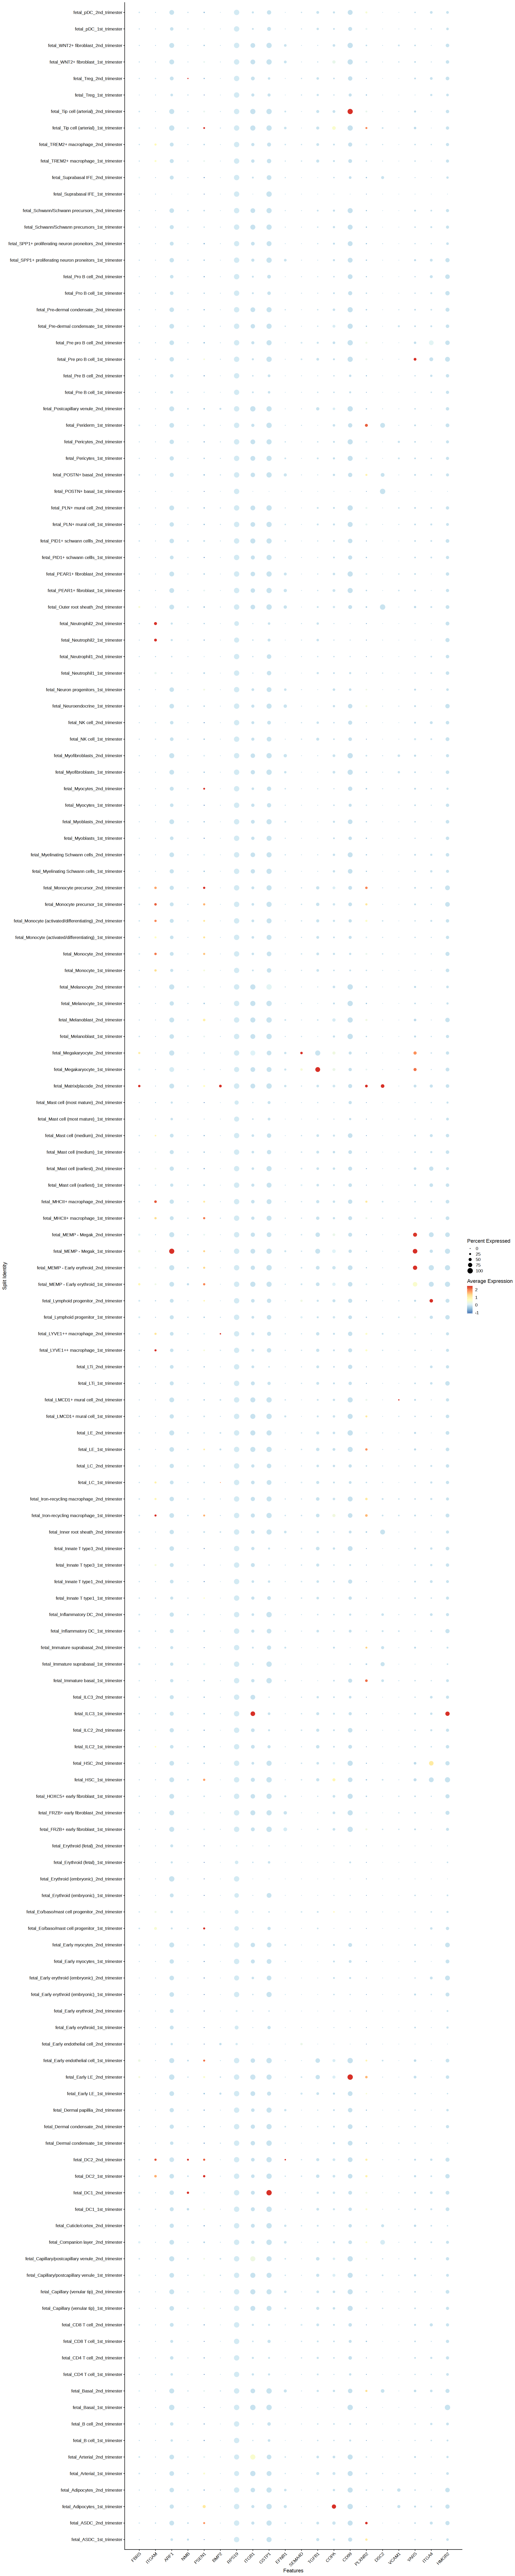

In [122]:
options(repr.plot.width=20, repr.plot.height=100)
print(
DotPlot(seuratObj, features = best_upstream_ligands %>% rev(), cols = "RdYlBu", split.by = 'trimester') + 
RotatedAxis() + 
scale_x_discrete(expand = c(0, 0.9)) + theme(axis.text.x = element_text(size = 12)))

 
![](seurat_steps_files/figure-gfm/unnamed-chunk-33-1.png)<!-- --> 
 
As you can see, most op the top-ranked ligands seem to be mainly 
expressed by dendritic cells and monocytes. 
 
## 5) Infer receptors and top-predicted target genes of ligands that are top-ranked in the ligand activity analysis 
 
### Active target gene inference 
 


In [123]:
active_ligand_target_links_df = best_upstream_ligands %>% lapply(get_weighted_ligand_target_links,geneset = geneset_oi, ligand_target_matrix = ligand_target_matrix, n = 200) %>% bind_rows() %>% drop_na() 
 
active_ligand_target_links = prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, ligand_target_matrix = ligand_target_matrix, cutoff = 0.33) 
 
order_ligands = intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev() %>% make.names() 
order_targets = active_ligand_target_links_df$target %>% unique() %>% intersect(rownames(active_ligand_target_links)) %>% make.names() 
rownames(active_ligand_target_links) = rownames(active_ligand_target_links) %>% make.names() # make.names() for heatmap visualization of genes like H2-T23 
colnames(active_ligand_target_links) = colnames(active_ligand_target_links) %>% make.names() # make.names() for heatmap visualization of genes like H2-T23 
 
vis_ligand_target = active_ligand_target_links[order_targets,order_ligands] %>% t() 


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


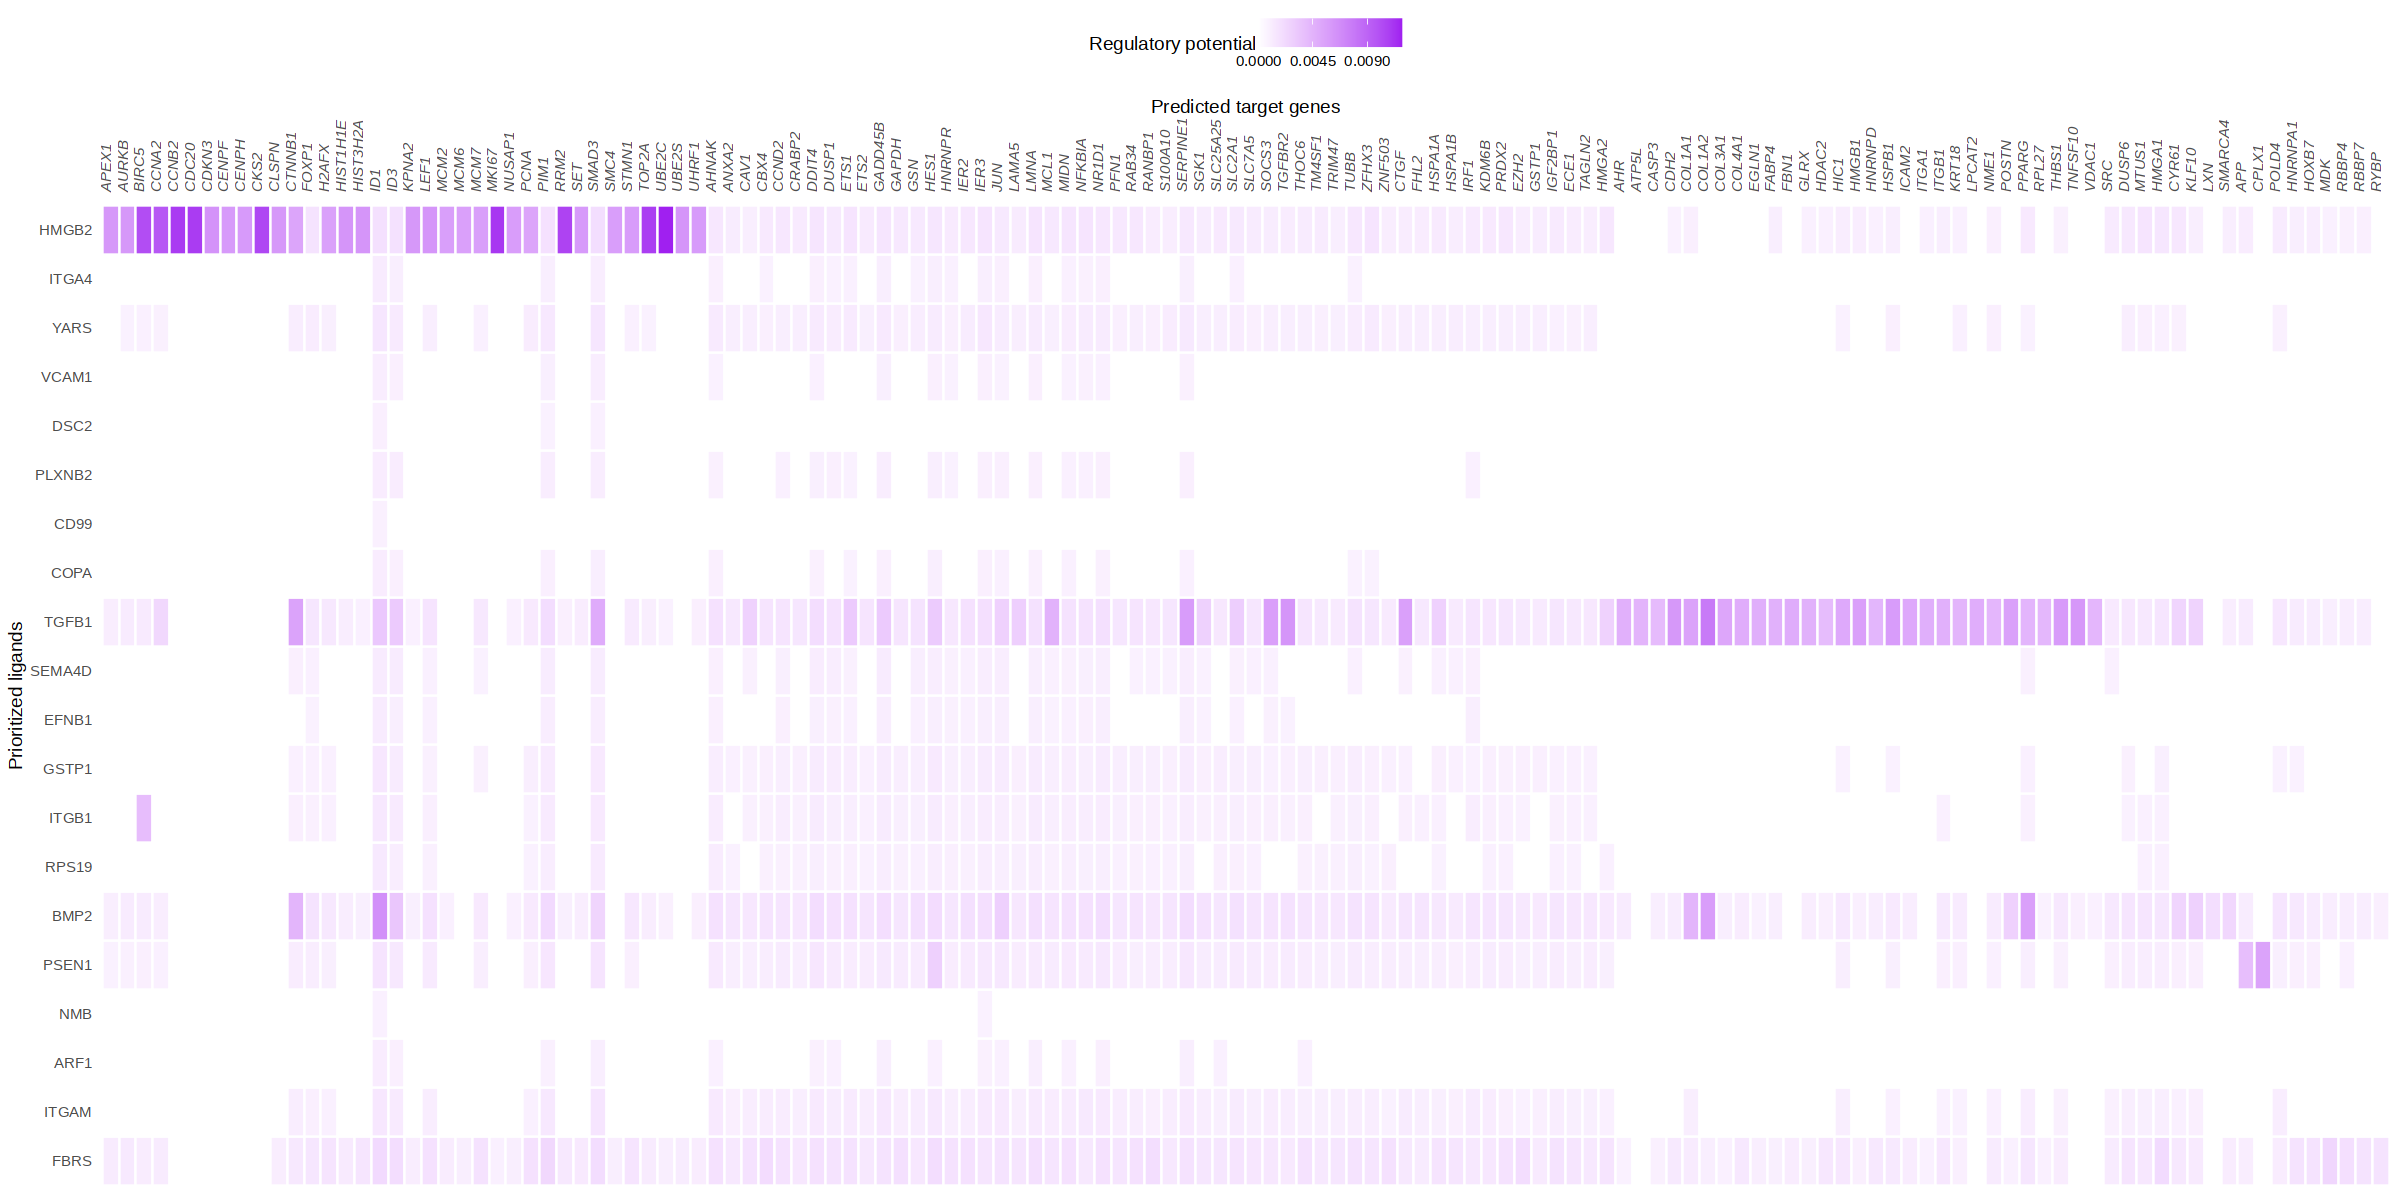

In [125]:
options(repr.plot.width=20, repr.plot.height=10)
p_ligand_target_network = vis_ligand_target %>% make_heatmap_ggplot("Prioritized ligands","Predicted target genes", color = "purple",legend_position = "top", x_axis_position = "top",legend_title = "Regulatory potential")  + theme(axis.text.x = element_text(face = "italic")) + scale_fill_gradient2(low = "whitesmoke",  high = "purple", breaks = c(0,0.0045,0.0090)) 
p_ligand_target_network 


 
![](seurat_steps_files/figure-gfm/unnamed-chunk-35-1.png)<!-- --> 
 
Note that not all ligands from the top 20 are present in this 
ligand-target heatmap. The left-out ligands are ligands that don’t have 
target genes with high enough regulatory potential scores. Therefore, 
they did not survive the used cutoffs. To include them, you can be less 
stringent in the used cutoffs. 
 
### Receptors of top-ranked ligands 
 


In [126]:
lr_network_top = lr_network %>% filter(from %in% best_upstream_ligands & to %in% expressed_receptors) %>% distinct(from,to) 
best_upstream_receptors = lr_network_top %>% pull(to) %>% unique() 
 
lr_network_top_df_large = weighted_networks_lr %>% filter(from %in% best_upstream_ligands & to %in% best_upstream_receptors) 
 
lr_network_top_df = lr_network_top_df_large %>% spread("from","weight",fill = 0) 
lr_network_top_matrix = lr_network_top_df %>% select(-to) %>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df$to) 
 
dist_receptors = dist(lr_network_top_matrix, method = "binary") 
hclust_receptors = hclust(dist_receptors, method = "ward.D2") 
order_receptors = hclust_receptors$labels[hclust_receptors$order] 
     
dist_ligands = dist(lr_network_top_matrix %>% t(), method = "binary") 
hclust_ligands = hclust(dist_ligands, method = "ward.D2") 
order_ligands_receptor = hclust_ligands$labels[hclust_ligands$order] 
 
order_receptors = order_receptors %>% intersect(rownames(lr_network_top_matrix)) 
order_ligands_receptor = order_ligands_receptor %>% intersect(colnames(lr_network_top_matrix)) 
 
vis_ligand_receptor_network = lr_network_top_matrix[order_receptors, order_ligands_receptor] 
rownames(vis_ligand_receptor_network) = order_receptors %>% make.names() 
colnames(vis_ligand_receptor_network) = order_ligands_receptor %>% make.names() 


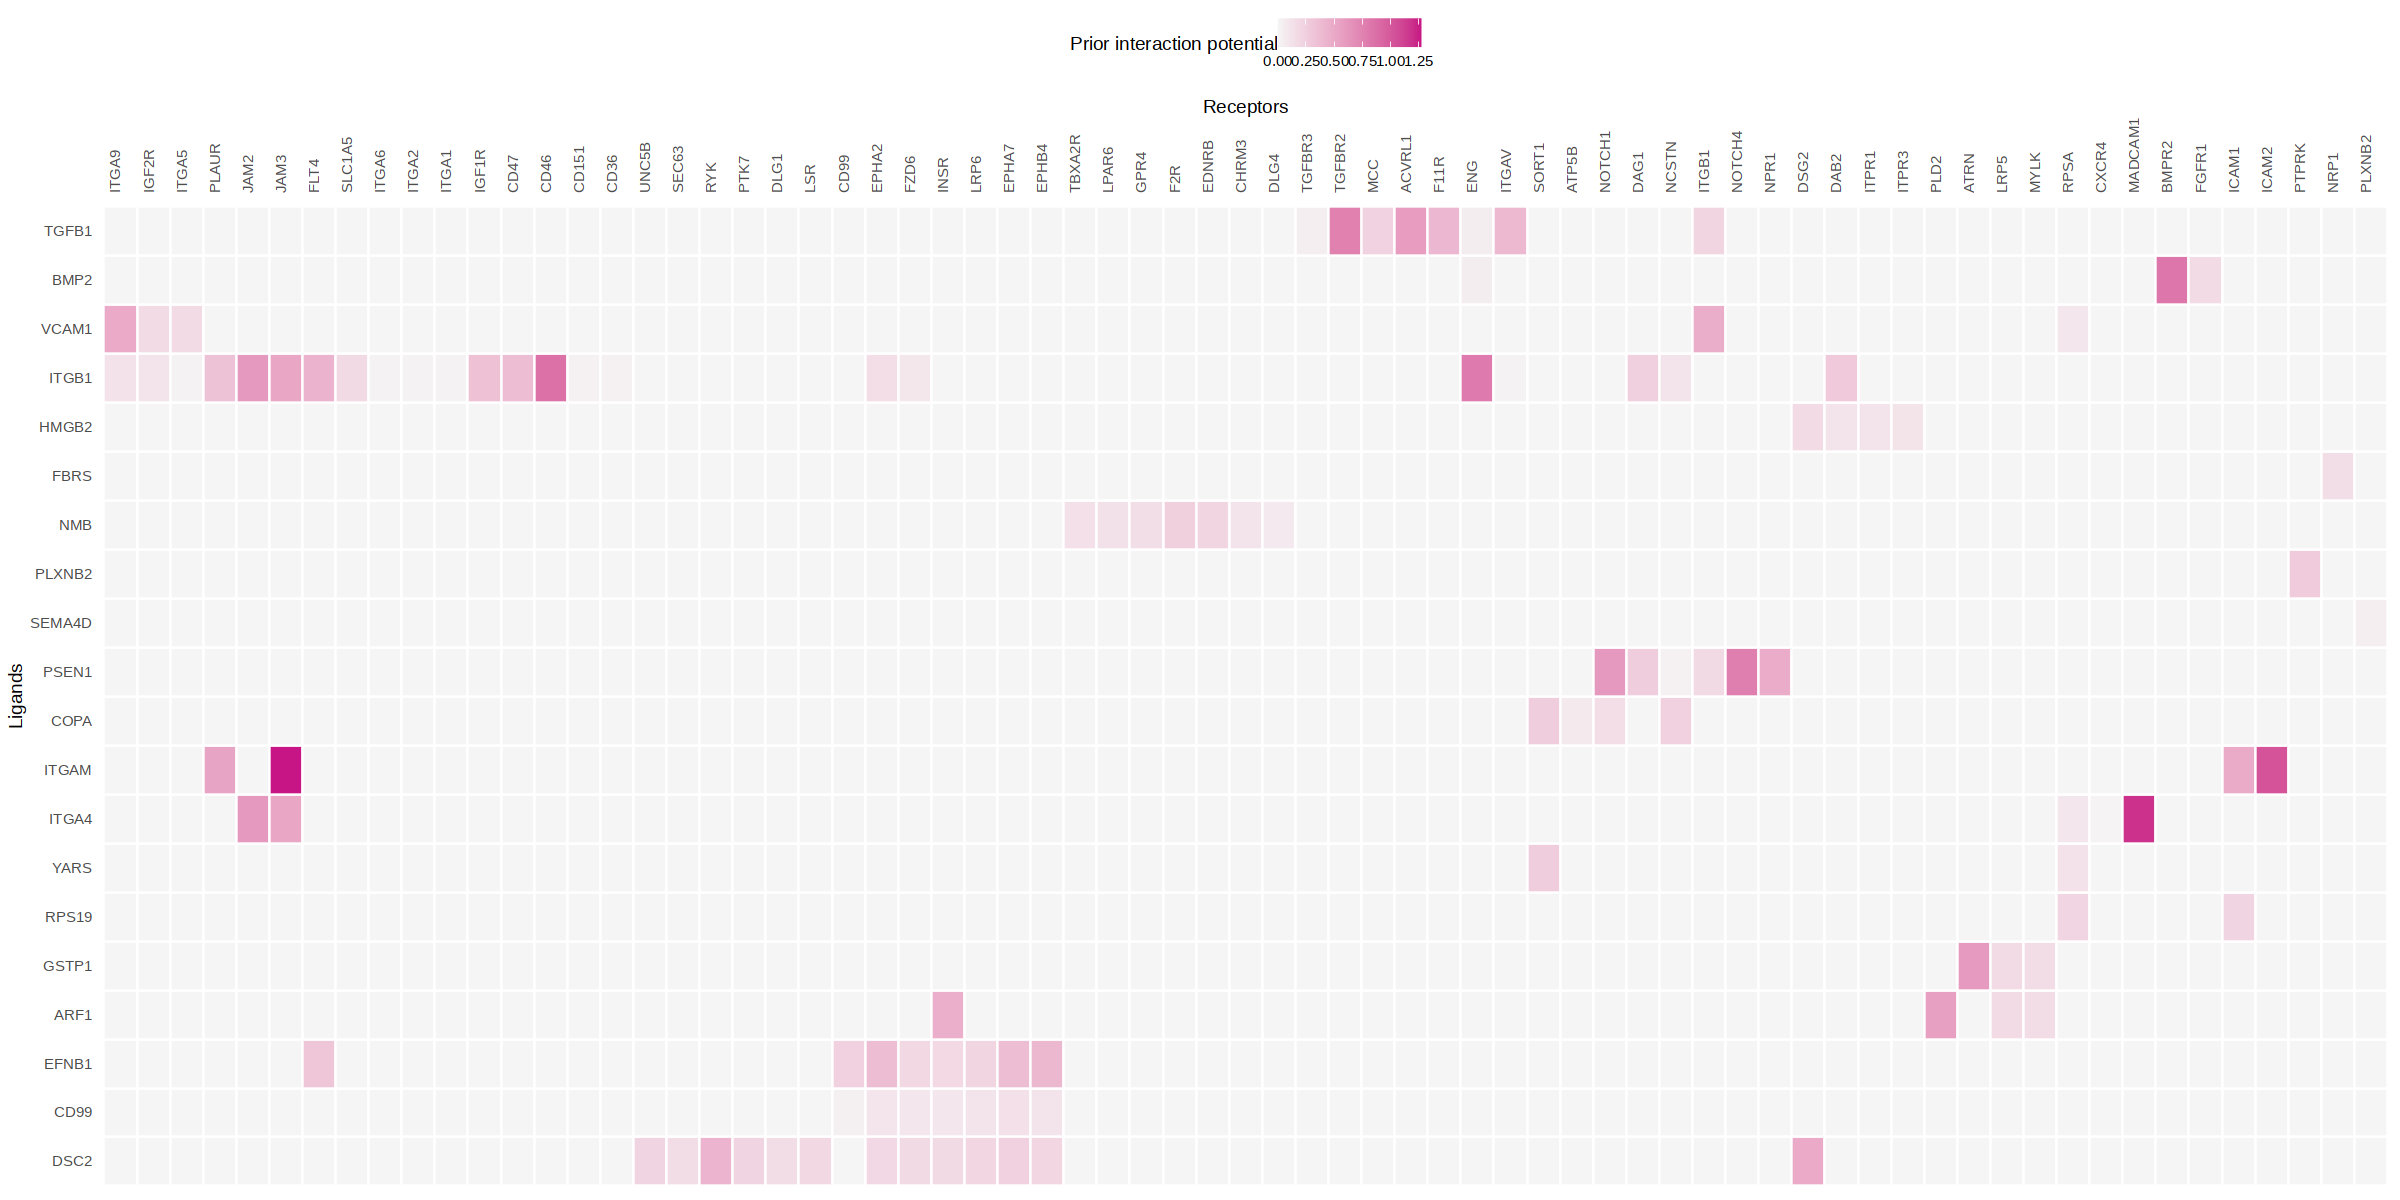

In [127]:
p_ligand_receptor_network = vis_ligand_receptor_network %>% t() %>% make_heatmap_ggplot("Ligands","Receptors", color = "mediumvioletred", x_axis_position = "top",legend_title = "Prior interaction potential") 
p_ligand_receptor_network 


 
![](seurat_steps_files/figure-gfm/unnamed-chunk-37-1.png)<!-- --> 
 
### Receptors of top-ranked ligands, but after considering only bona fide ligand-receptor interactions documented in literature and publicly available databases 
 


In [128]:
lr_network_strict = lr_network %>% filter(database != "ppi_prediction_go" & database != "ppi_prediction") 
ligands_bona_fide = lr_network_strict %>% pull(from) %>% unique() 
receptors_bona_fide = lr_network_strict %>% pull(to) %>% unique() 
 
lr_network_top_df_large_strict = lr_network_top_df_large %>% distinct(from,to) %>% inner_join(lr_network_strict, by = c("from","to")) %>% distinct(from,to) 
lr_network_top_df_large_strict = lr_network_top_df_large_strict %>% inner_join(lr_network_top_df_large, by = c("from","to")) 
 
lr_network_top_df_strict = lr_network_top_df_large_strict %>% spread("from","weight",fill = 0) 
lr_network_top_matrix_strict = lr_network_top_df_strict %>% select(-to) %>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df_strict$to) 
 
dist_receptors = dist(lr_network_top_matrix_strict, method = "binary") 
hclust_receptors = hclust(dist_receptors, method = "ward.D2") 
order_receptors = hclust_receptors$labels[hclust_receptors$order] 
 
dist_ligands = dist(lr_network_top_matrix_strict %>% t(), method = "binary") 
hclust_ligands = hclust(dist_ligands, method = "ward.D2") 
order_ligands_receptor = hclust_ligands$labels[hclust_ligands$order] 
 
order_receptors = order_receptors %>% intersect(rownames(lr_network_top_matrix_strict)) 
order_ligands_receptor = order_ligands_receptor %>% intersect(colnames(lr_network_top_matrix_strict)) 
 
vis_ligand_receptor_network_strict = lr_network_top_matrix_strict[order_receptors, order_ligands_receptor] 
rownames(vis_ligand_receptor_network_strict) = order_receptors %>% make.names() 
colnames(vis_ligand_receptor_network_strict) = order_ligands_receptor %>% make.names() 


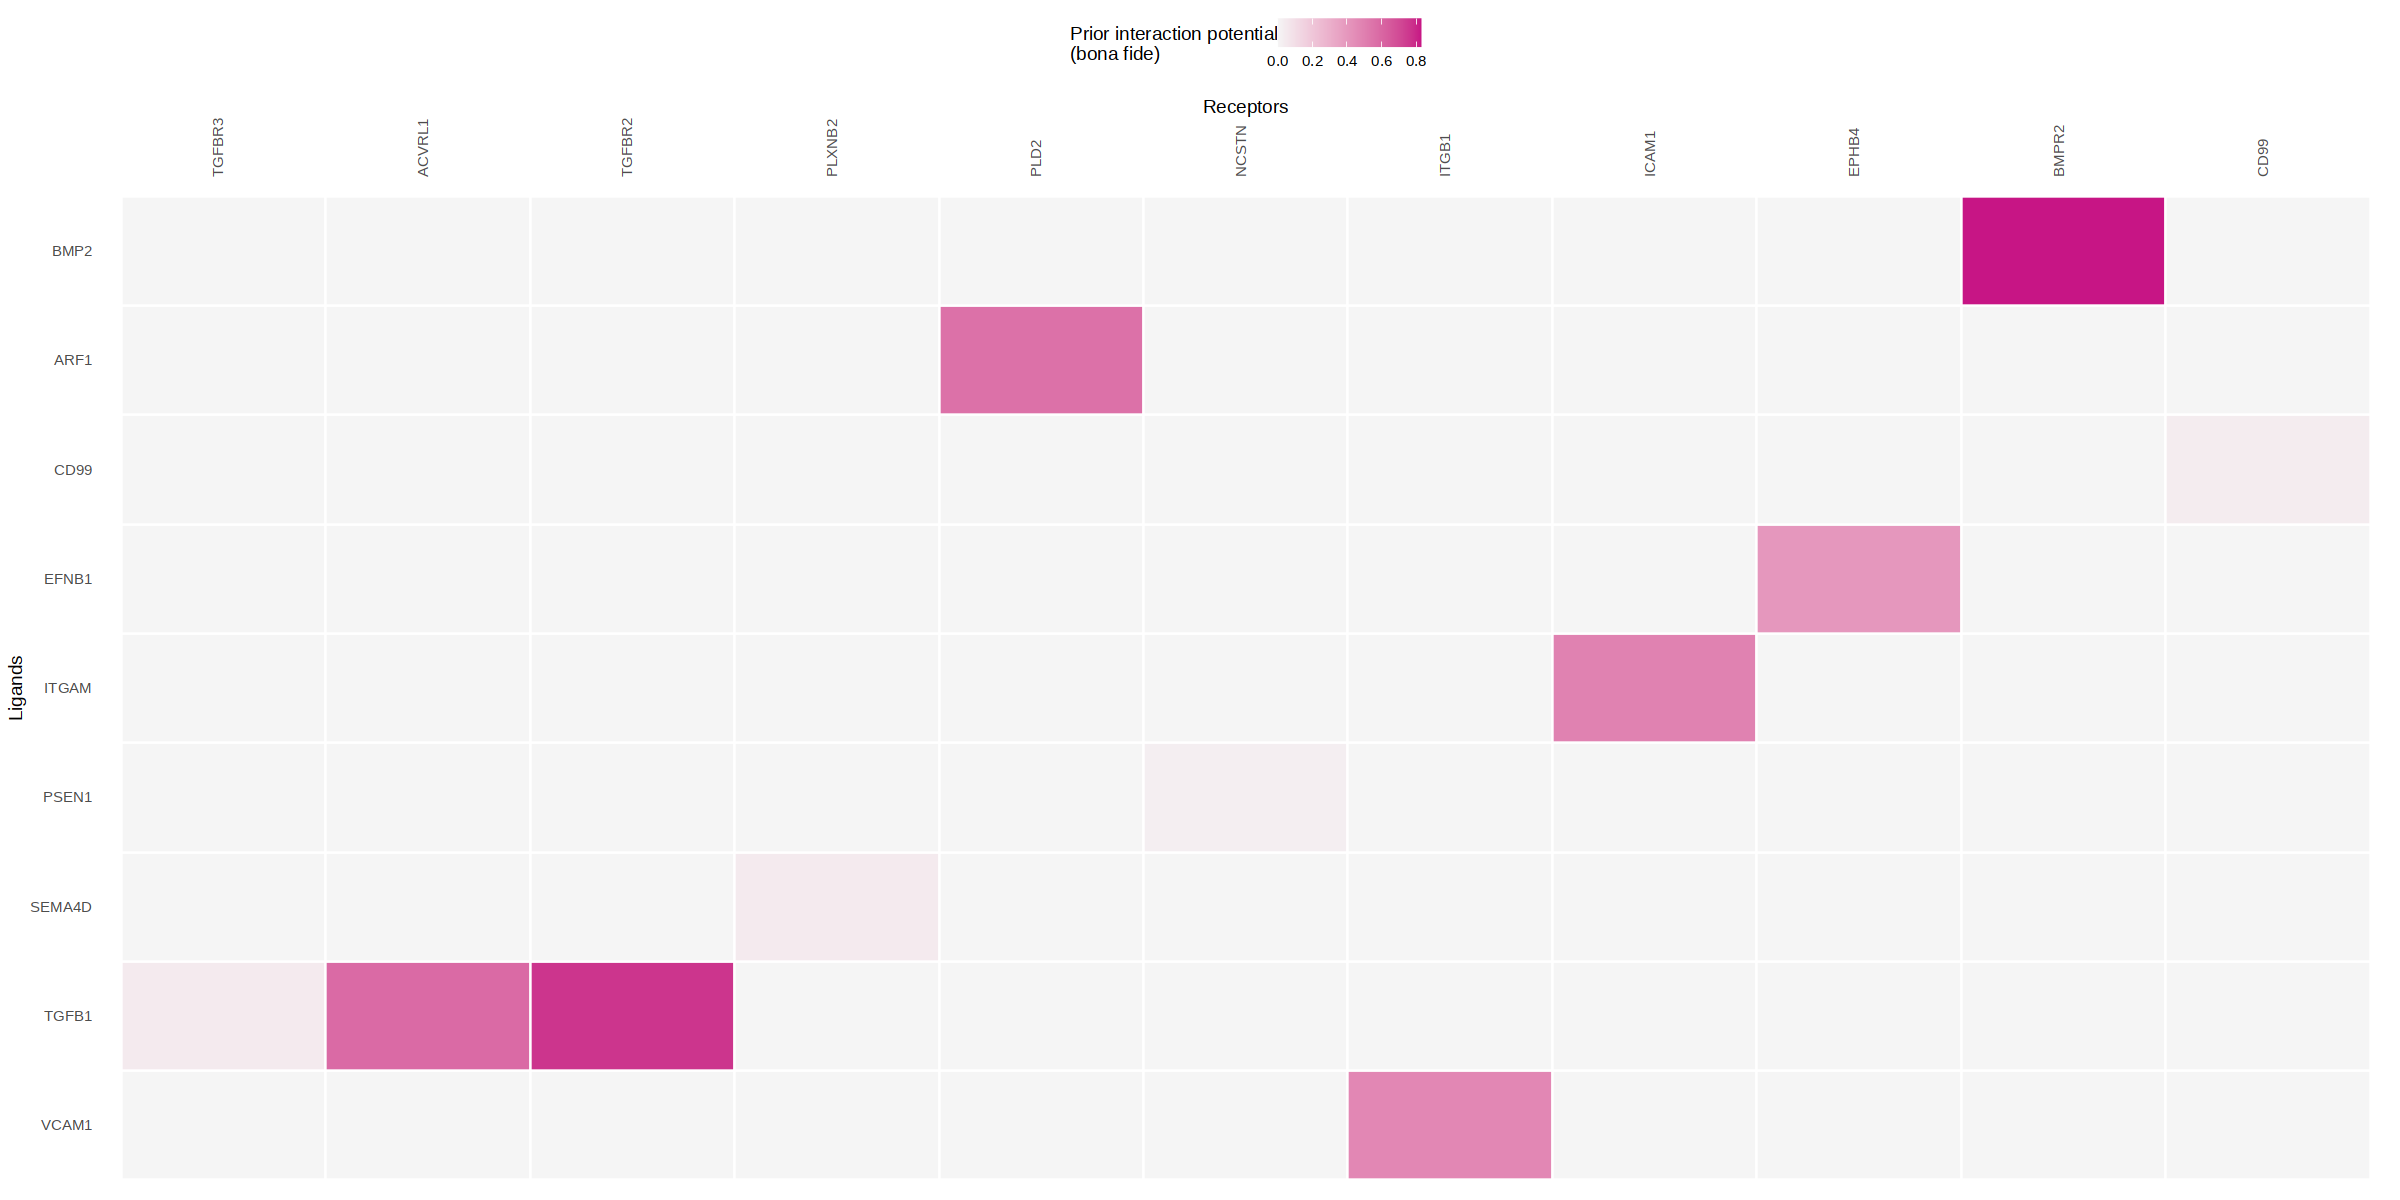

In [129]:
p_ligand_receptor_network_strict = vis_ligand_receptor_network_strict %>% t() %>% make_heatmap_ggplot("Ligands","Receptors", color = "mediumvioletred", x_axis_position = "top",legend_title = "Prior interaction potential\n(bona fide)") 
p_ligand_receptor_network_strict 


 
![](seurat_steps_files/figure-gfm/unnamed-chunk-39-1.png)<!-- --> 
 
## 6) Add log fold change information of ligands from sender cells 
 
In some cases, it might be possible to also check upregulation of 
ligands in sender cells. This can add a useful extra layer of 
information next to the ligand activities defined by NicheNet, because 
you can assume that some of the ligands inducing DE in receiver cells, 
will be DE themselves in the sender cells. 
 
Here this is possible: we will define the log fold change between LCMV 
and steady-state in all sender cell types and visualize this as extra 
information. 
 


Joining, by = "gene"
Joining, by = "gene"
Joining, by = "gene"
Joining, by = "ligand"


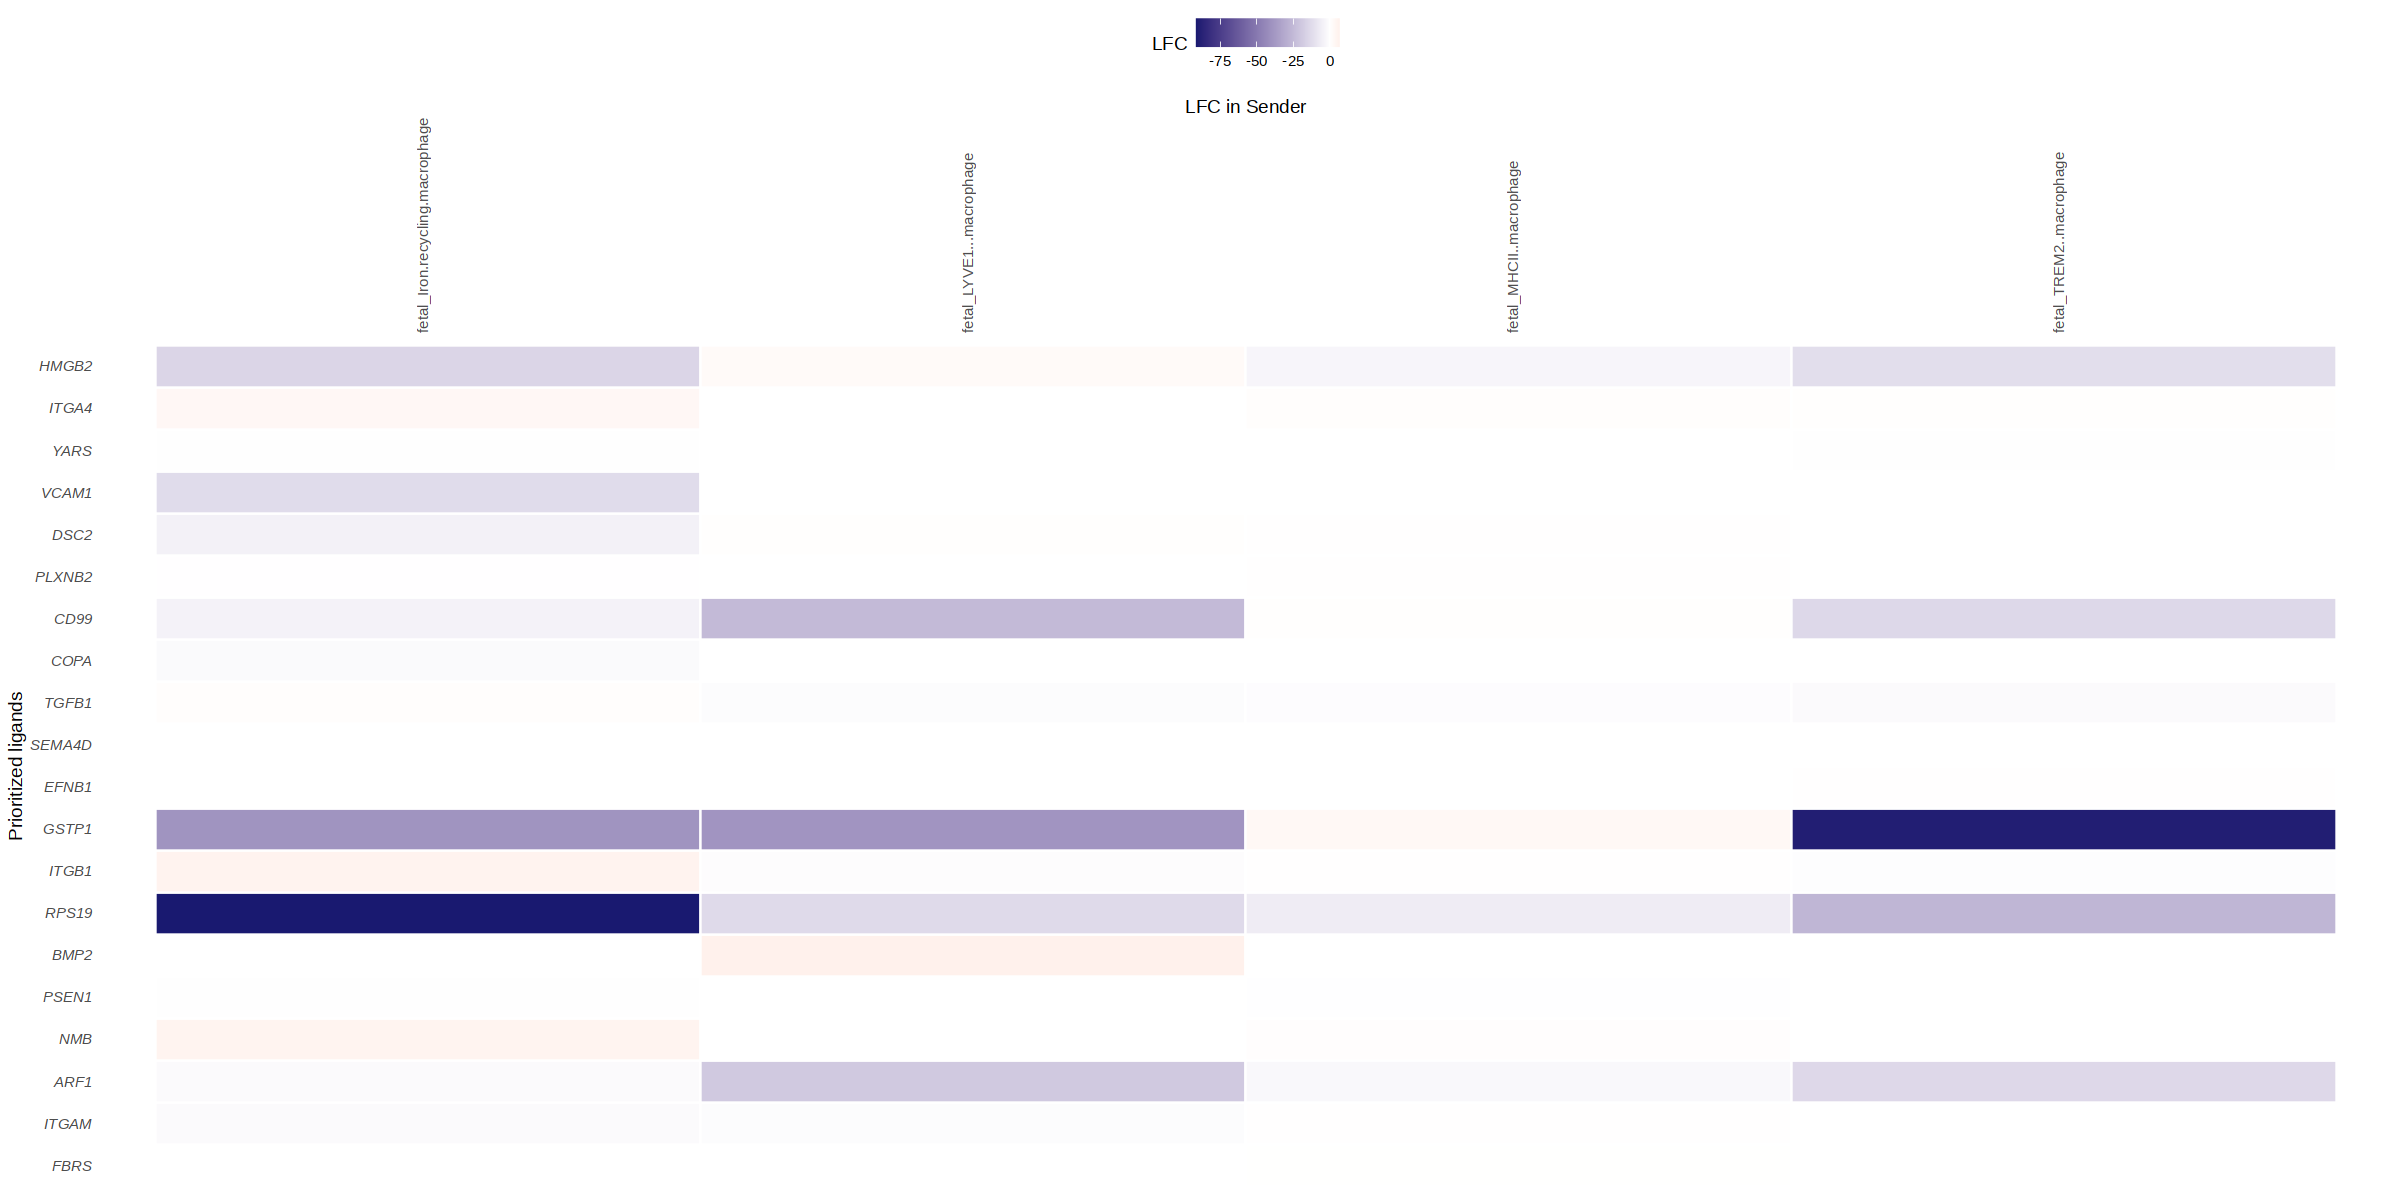

In [131]:
# DE analysis for each sender cell type 
# this uses a new nichenetr function - reinstall nichenetr if necessary! 
DE_table_all = Idents(seuratObj) %>% levels() %>% intersect(sender_celltypes) %>% lapply(get_lfc_celltype, seurat_obj = seuratObj, condition_colname = "trimester", condition_oi = condition_oi, condition_reference = condition_reference, expression_pct = 0.10, celltype_col = NULL) %>% reduce(full_join) # use this if cell type labels are the identities of your Seurat object -- if not: indicate the celltype_col properly 
DE_table_all[is.na(DE_table_all)] = 0 
 
# Combine ligand activities with DE information 
ligand_activities_de = ligand_activities %>% select(test_ligand, pearson) %>% rename(ligand = test_ligand) %>% left_join(DE_table_all %>% rename(ligand = gene)) 
ligand_activities_de[is.na(ligand_activities_de)] = 0 
 
# make LFC heatmap 
lfc_matrix = ligand_activities_de  %>% select(-ligand, -pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities_de$ligand) 
rownames(lfc_matrix) = rownames(lfc_matrix) %>% make.names() 
 
order_ligands = order_ligands[order_ligands %in% rownames(lfc_matrix)] 
vis_ligand_lfc = lfc_matrix[order_ligands,] 
 
colnames(vis_ligand_lfc) = vis_ligand_lfc %>% colnames() %>% make.names() 
 
p_ligand_lfc = vis_ligand_lfc %>% make_threecolor_heatmap_ggplot("Prioritized ligands","LFC in Sender", low_color = "midnightblue",mid_color = "white", mid = median(vis_ligand_lfc), high_color = "red",legend_position = "top", x_axis_position = "top", legend_title = "LFC") + theme(axis.text.y = element_text(face = "italic")) 
p_ligand_lfc 


 
![](seurat_steps_files/figure-gfm/unnamed-chunk-40-1.png)<!-- --> 
 


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


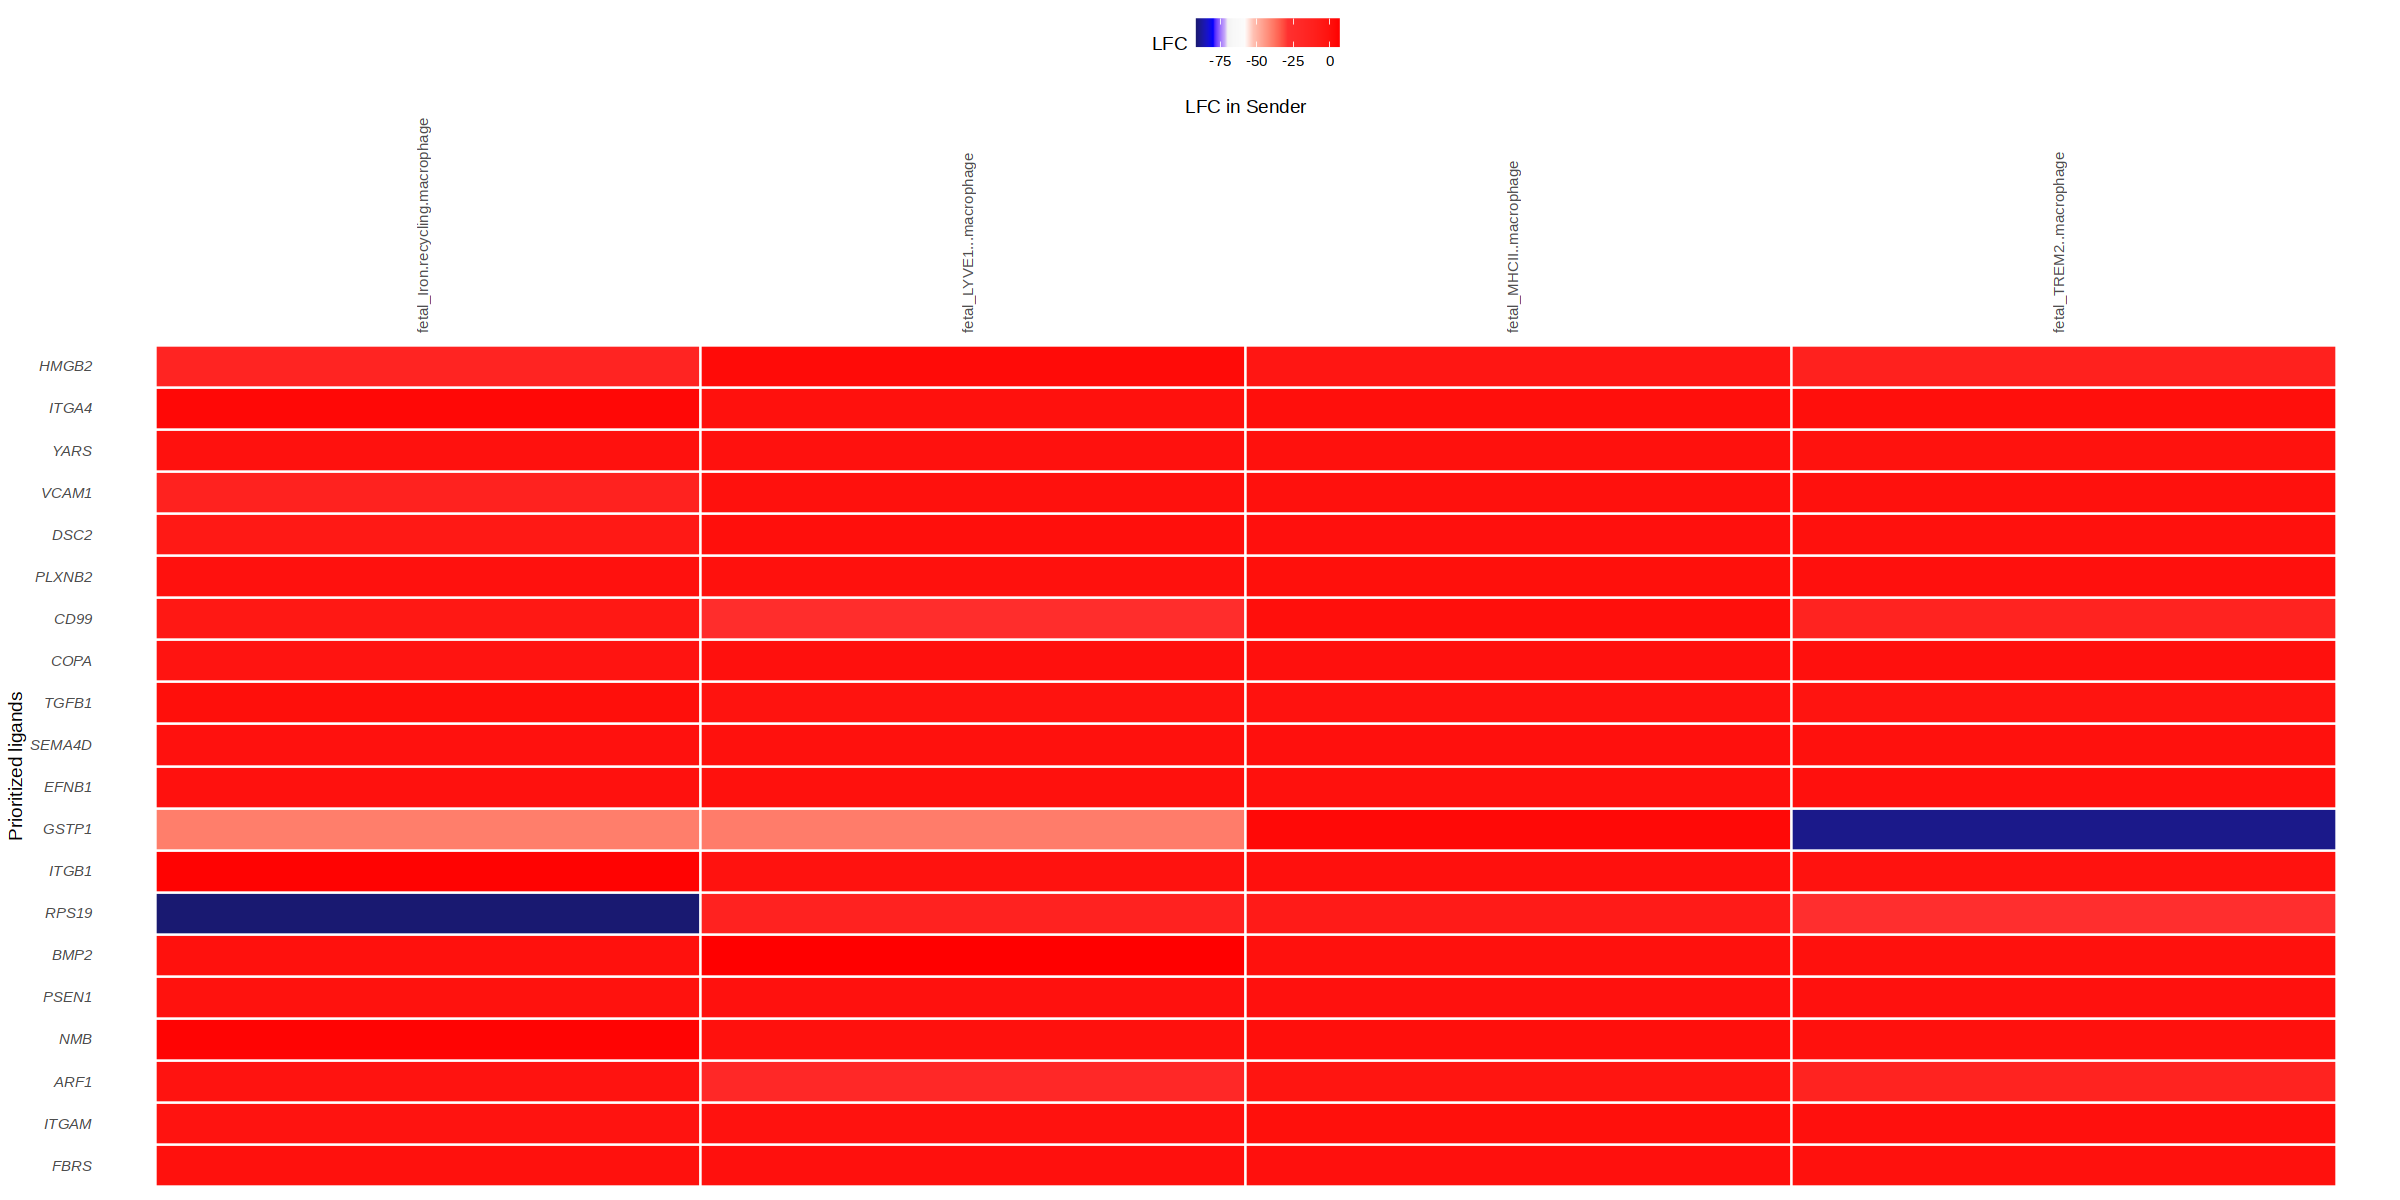

In [132]:
# change colors a bit to make them more stand out 
p_ligand_lfc = p_ligand_lfc + scale_fill_gradientn(colors = c("midnightblue","blue", "grey95", "grey99","firebrick1","red"),values = c(0,0.1,0.2,0.25, 0.40, 0.7,1), limits = c(vis_ligand_lfc %>% min() - 0.1, vis_ligand_lfc %>% max() + 0.1)) 
p_ligand_lfc 


 
![](seurat_steps_files/figure-gfm/unnamed-chunk-40-2.png)<!-- --> 
 
## 7) Summary visualizations of the NicheNet analysis 
 
For example, you can make a combined heatmap of ligand activities, 
ligand expression, ligand log fold change and the target genes of the 
top-ranked ligands. The plots for the log fold change and target genes 
were already made. Let’s now make the heatmap for ligand activities and 
for expression. 
 


In [133]:
# ligand activity heatmap 
ligand_pearson_matrix = ligand_activities %>% select(pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities$test_ligand) 
 
rownames(ligand_pearson_matrix) = rownames(ligand_pearson_matrix) %>% make.names() 
colnames(ligand_pearson_matrix) = colnames(ligand_pearson_matrix) %>% make.names() 
 
vis_ligand_pearson = ligand_pearson_matrix[order_ligands, ] %>% as.matrix(ncol = 1) %>% magrittr::set_colnames("Pearson") 
p_ligand_pearson = vis_ligand_pearson %>% make_heatmap_ggplot("Prioritized ligands","Ligand activity", color = "darkorange",legend_position = "top", x_axis_position = "top", legend_title = "Pearson correlation coefficient\ntarget gene prediction ability)") + theme(legend.text = element_text(size = 9)) 


In [144]:
# ligand expression Seurat dotplot 
order_ligands_adapted = order_ligands 
# order_ligands_adapted[order_ligands_adapted == "H2.M3"] = "H2-M3" # cf required use of make.names for heatmap visualization | this is not necessary if these ligands are not in the list of prioritized ligands! 
# order_ligands_adapted[order_ligands_adapted == "H2.T23"] = "H2-T23" # cf required use of make.names for heatmap visualization | this is not necessary if these ligands are not in the list of prioritized ligands! 
rotated_dotplot = DotPlot(seuratObj %>% subset(pooled_annot %in% sender_celltypes), features = order_ligands_adapted, cols = "RdYlBu") + coord_flip() + theme(legend.text = element_text(size = 10), legend.title = element_text(size = 12)) # flip of coordinates necessary because we want to show ligands in the rows when combining all plots 


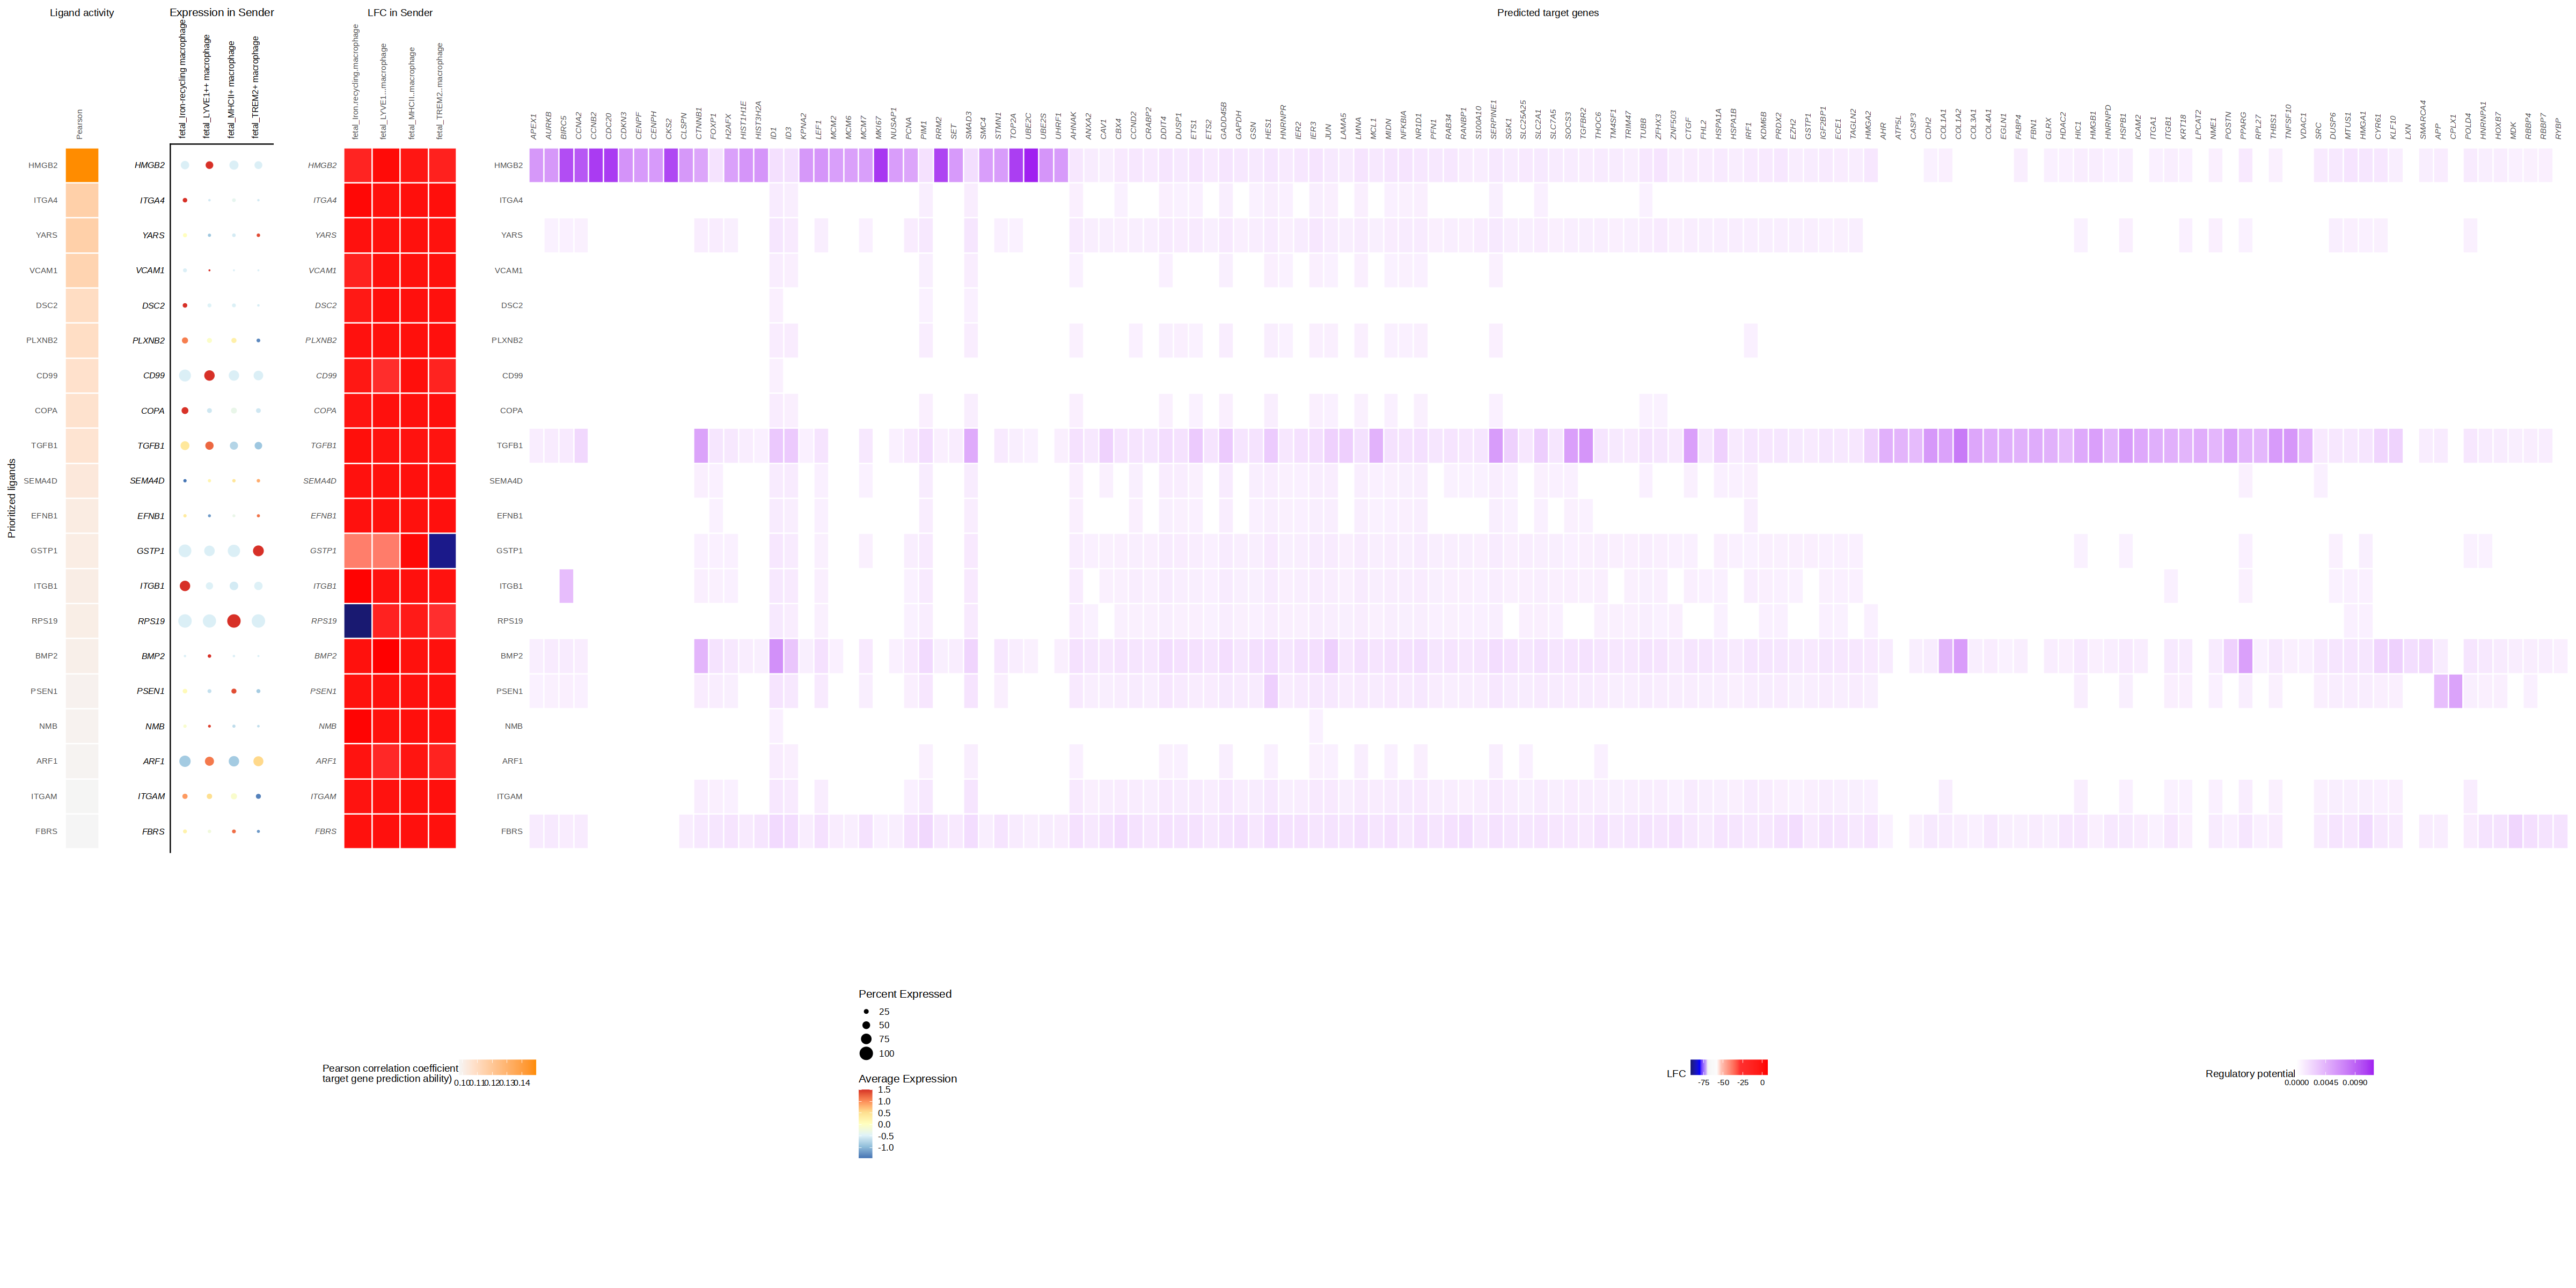

In [147]:
options(repr.plot.width=40, repr.plot.height=20)
figures_without_legend = cowplot::plot_grid( 
  p_ligand_pearson + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()), 
  rotated_dotplot + theme(legend.position = "none", axis.ticks = element_blank(), axis.title.x = element_text(size = 12), axis.text.y = element_text(face = "italic", size = 9), axis.text.x = element_text(size = 9,  angle = 90,hjust = 0)) + ylab("Expression in Sender") + xlab("") + scale_y_discrete(position = "right"), 
  p_ligand_lfc + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()) + ylab(""), 
  p_ligand_target_network + theme(legend.position = "none", axis.ticks = element_blank()) + ylab(""), 
  align = "hv", 
  nrow = 1, 
  rel_widths = c(ncol(vis_ligand_pearson)+6, ncol(vis_ligand_lfc) + 7, ncol(vis_ligand_lfc) + 8, ncol(vis_ligand_target))) 
 
legends = cowplot::plot_grid( 
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_pearson)), 
    ggpubr::as_ggplot(ggpubr::get_legend(rotated_dotplot)), 
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_lfc)), 
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_target_network)), 
    nrow = 1, 
    align = "h", rel_widths = c(1.5, 1, 1, 1)) 
 
combined_plot = cowplot::plot_grid(figures_without_legend, legends, rel_heights = c(10,5), nrow = 2, align = "hv") 
combined_plot 


 
![](seurat_steps_files/figure-gfm/unnamed-chunk-43-1.png)<!-- --> 
 
# Remarks 
 
1.  Top-ranked ligands and target genes shown here differ from the 
    predictions shown in the respective case study in the NicheNet paper 
    because a different definition of expressed genes was used. 
 
# References 
 
<div id="refs" class="references csl-bib-body hanging-indent"> 
 
<div id="ref-medaglia_spatial_2017" class="csl-entry"> 
 
Medaglia, Chiara, Amir Giladi, Liat Stoler-Barak, Marco De Giovanni, 
Tomer Meir Salame, Adi Biram, Eyal David, et al. 2017. “Spatial 
Reconstruction of Immune Niches by Combining Photoactivatable Reporters 
and <span class="nocase">scRNA</span>-Seq.” *Science*, December, 
eaao4277. <https://doi.org/10.1126/science.aao4277>. 
 
</div> 
 
</div> 
